,Macro F1,Micro F1,Subset Acc
Model,,,
Two Dense,0.696272,0.793699,0.742667
Single Dense,0.695551,0.791013,0.741075
Attention,0.695443,0.790663,0.742439


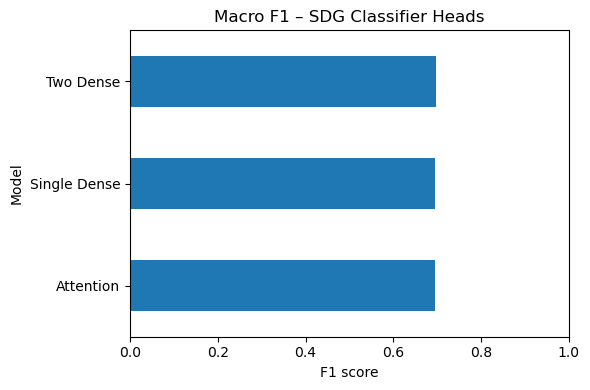

In [1]:
# 📊 Compare model heads – run this AFTER training has finished
from pathlib import Path
import json, pandas as pd, matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1️⃣ Locate the metrics
# ------------------------------------------------------------------
ROOT = Path("/home/jovyan/Training_Model/models/sdg_bert_v1")  # <-- same as cfg.out_dir
MODEL_DIRS = {
    "Single Dense" : ROOT / "single_dense",      # adjust names if you changed them
    "Two Dense"    : ROOT / "two_dense",
    "Attention"    : ROOT / "attention_based",   # maybe "attention" in your run
}

records = []
for name, folder in MODEL_DIRS.items():
    m_file = folder / "metrics.json"
    if not m_file.exists():
        print(f"⚠️  {name}: metrics.json not found, skipping.")
        continue
        
    with open(m_file) as fp:
        raw = json.load(fp)
        
    # script version saved like {"test": {...}} – pick the right level:
    test_metrics = raw.get("test", raw)          # works for both layouts
    records.append({
        "Model"      : name,
        "Macro F1"   : test_metrics.get("eval_macro_f1") or test_metrics.get("test_macro_f1"),
        "Micro F1"   : test_metrics.get("eval_micro_f1") or test_metrics.get("test_micro_f1"),
        "Subset Acc" : test_metrics.get("eval_subset_accuracy") or test_metrics.get("test_subset_accuracy"),
    })

df = pd.DataFrame(records).set_index("Model").sort_values("Macro F1", ascending=False)
display(df)   # nice table in a notebook
# ------------------------------------------------------------------
# 2️⃣ Plot!
# ------------------------------------------------------------------
plt.figure(figsize=(6,4))
df["Macro F1"].plot(kind="barh")
plt.title("Macro F1 – SDG Classifier Heads")
plt.xlabel("F1 score")
plt.xlim(0,1)
plt.gca().invert_yaxis();   # best model on top
plt.tight_layout()
plt.show()


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

MODEL_DIR = "/home/jovyan/Training_Model/models/sdg_bert_v1/single_dense/checkpoint-30784"
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)

def classify_text(text, threshold=0.7, max_length=512):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=max_length
    )
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    if hasattr(model.config, "id2label") and model.config.id2label:
        id2label = {int(k): v for k, v in model.config.id2label.items()}
    else:
        id2label = {i: f"sdg_{i}" for i in range(len(probs))}
    results = [(id2label[i], float(prob)) for i, prob in enumerate(probs) if prob >= threshold]
    results.sort(key=lambda x: x[1], reverse=True)
    return results

# --- Main Loop ---
print("Enter your text for SDG classification (empty input or 'exit' to quit):")
while True:
    try:
        text = input("Paste text: ")
        if not text.strip() or text.lower() == "exit":
            print("Exiting.")
            break
        results = classify_text(text, threshold=0.5)
        if results:
            print("Predicted SDGs above threshold:")
            for label, prob in results:
                print(f"  {label:25}  {prob:.3f}")
        else:
            print("No SDG predicted above threshold.")
        print("-" * 40)
    except KeyboardInterrupt:
        print("\nInterrupted by user (ESC/Ctrl+C). Exiting.")
        break


Enter your text for SDG classification (empty input or 'exit' to quit):


Paste text:  "This invention discloses an intelligent building-integrated energy skin that marries semi-transparent perovskite-silicon "             "tandem photovoltaic modules (PV) with a micro-channel proton-exchange–membrane electrolyzer sandwiched behind the glazing. "             "During daylight hours, DC output from the 28 %-efficient PV stack is pulse-modulated to match the electrolyzer’s maximum "             "power curve, generating 99.9 %-pure hydrogen at 30 bar without external converters. At dusk, the hydrogen is metered to a "             "solid-oxide fuel cell, supplying baseload power that keeps the building net-positive over a 24-hour cycle.\n\n"             "An integrated thermal loop harvests waste heat from both the electrolyzer (≈60 °C) and the fuel cell (≈700 °C), "             "feeding an absorption chiller that offsets HVAC demand. Smart glazed louvers pivot to optimize daylighting versus power "             "production, guided by a reinforcement-learning contr

Predicted SDGs above threshold:
  LABEL_7                    0.993
----------------------------------------


Paste text:  "A cylindrical, 3 000 L rooftop rainwater tank equipped with an ultrasonic depth sensor, turbidity probe, and LTE-M "             "modem continuously uploads fill-level and water-quality data to a cloud dashboard. A Bayesian-optimized controller "             "combines 72-h NOAA rainfall forecasts with household usage profiles to decide when to purge first-flush water, "             "activate the UV-LED disinfection sleeve, and drive a variable-speed booster pump. Field pilots in Manila supplied "             "78 % of non-potable demand and cut municipal storm-drain overflow by 12 % during monsoon peaks."


No SDG predicted above threshold.
----------------------------------------


Paste text:  "A cylindrical, 3 000 L rooftop rainwater tank equipped with an ultrasonic depth sensor, turbidity probe, and LTE-M "             "modem continuously uploads fill-level and water-quality data to a cloud dashboard. A Bayesian-optimized controller "             "combines 72-h NOAA rainfall forecasts with household usage profiles to decide when to purge first-flush water, "             "activate the UV-LED disinfection sleeve, and drive a variable-speed booster pump. Field pilots in Manila supplied "             "78 % of non-potable demand and cut municipal storm-drain overflow by 12 % during monsoon peaks."


No SDG predicted above threshold.
----------------------------------------


Paste text:  "Microalgae are cultivated in photobioreactors that precipitate CaCO₃ nanofibers using flue-gas CO₂ at 40 °C. The "             "biogenic limestone replaces 65 % of clinker feedstock; remaining CO₂ from kiln exhaust is mineralized in situ by "             "injecting magnesium silicate tailings, yielding a net –110 kg CO₂e per tonne of cement. Pilot pours for highway "             "pavement slabs met ASTM C150 strength after 28 days and showed 8 % higher fracture toughness."         


Predicted SDGs above threshold:
  LABEL_15                   0.916
----------------------------------------


Paste text:  "An upper-limb prosthesis printed in PA-CF composite integrates eight dry-electrode EMG pads and a quaternion-based "             "IMU. A tinyML CNN retrains on-device each night, learning new muscle activation patterns to improve grasp force "             "accuracy by 0.8 N per day. The socket’s lattice structure is parametrically generated from the wearer’s 3-D scan, "             "cutting fabrication time to 9 h and total cost below US$350."


Predicted SDGs above threshold:
  LABEL_3                    0.910
----------------------------------------


Paste text:   "A nanoparticle-stabilized double-stranded RNA (dsRNA) formulation silences the cathepsin-L gene in Spodoptera "             "frugiperda within 48 h, causing >80 % larval mortality while leaving non-target Lepidoptera unharmed. The dsRNA is "             "encapsulated in chitosan–silica shells that resist UV for 14 days and degrade enzymatically in soil. Maize trial "             "plots across Kenya showed a 22 % yield gain compared with chemical chlorantraniliprole applications."


No SDG predicted above threshold.
----------------------------------------


Paste text:  "A plug-and-play DC bus (48 V ↔ 350 V) that auto-detects retired EV modules and re-bins cells through on-board EIS "             "to build a balanced 10 kWh–50 kWh stack. Power-flow is managed by a GaN bidirectional converter achieving 96.5 % "             "round-trip efficiency. The controller predicts PV output using a lightweight Transformer model running on an ESP32, "             "enabling time-shifting of 8 000+ cycle-aged cells for another 7 years of rural electrification service."


Predicted SDGs above threshold:
  LABEL_7                    0.987
----------------------------------------


Paste text:  "A cylindrical, 3 000 L rooftop rainwater tank equipped with an ultrasonic depth sensor, turbidity probe, and LTE-M "             "modem continuously uploads fill-level and water-quality data to a cloud dashboard. A Bayesian-optimized controller "             "combines 72-h NOAA rainfall forecasts with household usage profiles to decide when to purge first-flush water, "             "activate the UV-LED disinfection sleeve, and drive a variable-speed booster pump. Field pilots in Manila supplied "             "78 % of non-potable demand and cut municipal storm-drain overflow by 12 % during monsoon peaks."  


No SDG predicted above threshold.
----------------------------------------


Paste text:  A modular vertical farming system designed for urban environments integrates automated climate control, nutrient delivery, and adaptive lighting into a compact, energy-efficient architecture. Each growth module consists of stacked aeroponic trays with integrated mist nozzles that deliver a fine nutrient solution directly to the root zone, reducing water usage by 85% compared to traditional hydroponics.  The system is powered by a hybrid renewable energy unit comprising flexible solar panels and a small vertical-axis wind turbine. Real-time monitoring of pH, EC (electrical conductivity), humidity, CO₂ levels, and plant health is conducted via an array of IoT sensors. Data is aggregated on a central cloud platform and analyzed using a machine learning model trained to optimize plant growth under varying environmental conditions.  A self-adjusting LED lighting system employs a tunable spectrum to optimize photosynthesis, reducing energy consumption by 30% during non-peak hour

Predicted SDGs above threshold:
  LABEL_2                    0.919
  LABEL_7                    0.615
----------------------------------------


Paste text:  A decentralized biofuel production system designed to convert agricultural waste and fast-growing microalgae into biodiesel and bioethanol. The reactor employs a two-stage process: enzymatic hydrolysis followed by catalytic transesterification. In the first stage, agricultural residues such as rice husks and corn stover undergo enzymatic breakdown using cellulase derived from genetically engineered fungi, producing a fermentable sugar solution. Simultaneously, microalgae biomass cultivated in photobioreactors is harvested and processed to extract lipids using a supercritical CO₂ method.  The second stage involves catalytic transesterification, where the extracted lipids react with methanol in the presence of a sodium hydroxide catalyst, producing biodiesel. The remaining sugar-rich liquid undergoes anaerobic fermentation to generate bioethanol. The integrated heat recovery system captures excess heat from the transesterification process to maintain optimal enzymatic activi

Predicted SDGs above threshold:
  LABEL_7                    0.844
  LABEL_12                   0.721
----------------------------------------

Interrupted by user (ESC/Ctrl+C). Exiting.
